In [11]:
%matplotlib inline 

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [12]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [13]:
learning_rate = 0.001
training_iters = 250
batch_size = 128
display_step = 50

# Network Parameters
n_input = 784  # MNIST data input (img shape: 28*28)
n_classes = 10  # MNIST total classes (0-9 digits)
dropout = 0.75  # Dropout, probability to keep units

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)

In [14]:
# Create some wrappers for simplicity

# Conv2D wrapper, with bias and relu activation
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W,
                     strides=[1, strides, strides, 1],
                     padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


# MaxPool2D wrapper
def maxpool2d(x, k=2):
    return tf.nn.max_pool(x,
                          ksize=[1, k, k, 1],
                          strides=[1, k, k, 1],
                          padding='SAME')


# Create model
def conv_net(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 28, 28, 1])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    # Max Pooling (down-sampling)
    conv2 = maxpool2d(conv2, k=2)

    # Fully connected layer
    # Reshape conv2 output to fit fully connected layer input
    fc1 = tf.reshape(conv2, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)

    # Output, class prediction
    out = tf.add(tf.matmul(fc1, weights['out']), biases['out'])
    return out

# predict the class of the sample
def predict(logits):
    return tf.argmax(logits, axis=1)

In [15]:
# Store layers weight & bias
weights = {
    # 5x5 conv, 1 input, 32 outputs
    'wc1': tf.Variable(tf.random_normal([5, 5, 1, 32])),
    # 5x5 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([5, 5, 32, 64])),
    # fully connected, 7*7*64 inputs, 1024 outputs
    'wd1': tf.Variable(tf.random_normal([7 * 7 * 64, 1024])),
    # 1024 inputs, 10 outputs (class prediction)
    'out': tf.Variable(tf.random_normal([1024, n_classes]))
}

biases = {
    'bc1': tf.Variable(tf.random_normal([32])),
    'bc2': tf.Variable(tf.random_normal([64])),
    'bd1': tf.Variable(tf.random_normal([1024])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}


In [16]:
# Construct model
pred = conv_net(x, weights, biases, keep_prob)

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# predict the class of the sample
pred_class = predict(pred)

# Initializing the variables
init = tf.global_variables_initializer()

Iter 0, Minibatch Loss= 71410.773438, Training Accuracy= 0.19531
Iter 50, Minibatch Loss= 2985.206787, Training Accuracy= 0.82812
Iter 100, Minibatch Loss= 3110.320801, Training Accuracy= 0.85938
Iter 150, Minibatch Loss= 3857.772949, Training Accuracy= 0.85156
Iter 200, Minibatch Loss= 1410.009644, Training Accuracy= 0.94531
Optimization Finished!
Testing Accuracy: 0.9375


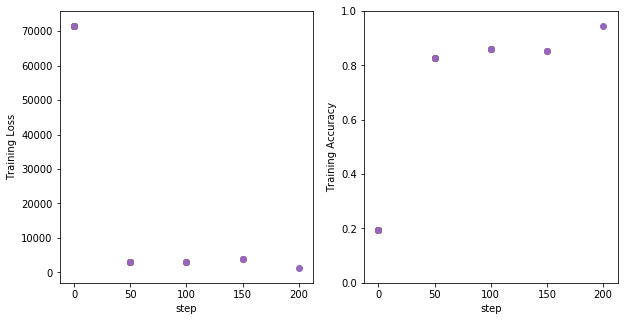

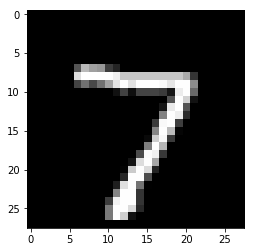

Model prediction: 7


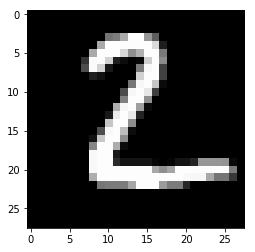

Model prediction: 2


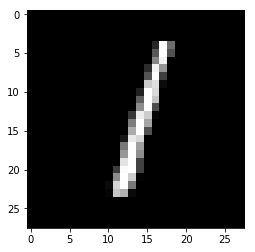

Model prediction: 1


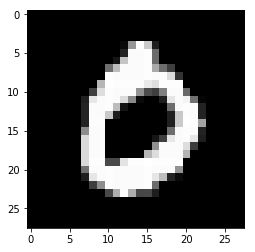

Model prediction: 0


In [18]:
# make a figure to show the loss
def makeFig(ax, xlist, ylist):
    ax.scatter(xlist, ylist)
    
# creating the figure and adjusting its settings
fig, axs = plt.subplots(nrows=1, ncols=2, sharex=True)
plt.ion()  # enable interactivity
fig.set_size_inches(10, 5)
ax0 = axs[0]
ax0.set_ylabel('Training Loss')
ax0.set_xlabel('step')
ax1 = axs[1]
ax1.set_ylim([0, 1])
ax1.set_ylabel('Training Accuracy')
ax1.set_xlabel('step')

xList = list()
lossList = list()
accList = list()


# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # step = 1
    # Keep training until reach max iterations
    for step in range(training_iters):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                       keep_prob: dropout})
        if step % display_step == 0:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y,
                                                              keep_prob: 1.})
            print("Iter " + str(step) + ", Minibatch Loss= " +
                  "{:.6f}".format(loss) + ", Training Accuracy= " +
                  "{:.5f}".format(acc))
            xList.append(step)
            lossList.append(loss)
            accList.append(acc)
            # Plot loss
            makeFig(ax0, xList, lossList)
            # plt.draw()
            plt.pause(0.001)
            # Plot accuracy
            makeFig(ax1, xList, accList)
            plt.draw()

    # Saving the figure at the end
    fig.savefig('training_curves.png')
    print("Optimization Finished!")

    # test the network
    # Calculate accuracy
    print("Testing Accuracy:",
          sess.run(accuracy, feed_dict={x: mnist.test.images[:256],
                                        y: mnist.test.labels[:256],
                                        keep_prob: 1.}))
    # Predict single images
    n_images = 4
    test_images = mnist.test.images[:n_images]
    preds = sess.run(pred_class, feed_dict={x: test_images,
                                            keep_prob: 1.})
    # Display
    for i in range(n_images):
        plt.figure()
        plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
        plt.show()
        print("Model prediction:", preds[i])
